# RIB0107 - Fundamentos de Informática em Imagens Médicas: Avaliação Parcial 3
## GRUPO 2: <inserir nomes>
### Construção e treinamento de um modelo de classificação baseado em rede neural convolucional para a diferenciação de fraturas vertebrais por compressão benignas e malignas

### 1. Importação de bibliotecas

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Importação da base de dados
Notas:
A base foi organizada pela Informata Biomédica (ex-aluna de nosso curso) Natália Santana Chiari Correia, como parte de sua pesquisa de doutorado no Programa de Pós-Graduação em Clínica Médica da FMRP, sob orientação dos Profs. Paulo e Marcello.

ATENÇÃO: Essa base é para uso exclusivo na disciplina e não pode ser compartilhada ou utilizada para outras finalidades sem autorização específica dos professores ou da sua organizadora.

A base contém:

- Os exames originais em formato DICOM anonimizados.
- Um arquivo .xlsx com a classe de cada paciente, o sexo, a idade e quais corpos vertebrais foram segmentados.
- Outras duas pastas além dos exames originais: uma com as imagens requantizadas para 256 níveis de tons de cinza no formato .nrrd e outra com os arquivos de segmentação no formato .seg.nrrd.

In [ ]:
! cp -r '/content/drive/MyDrive/USP/Disciplinas/4º Período/RIB0107 - Fundamentos de Informática em Imagens Médicas/TrabalhoPratico3/dados' '/content/'

In [ ]:
! unzip '/content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip'
! unzip '/content/dados/Cópia de 2-Rescaled_256_NRRD-20220915T191517Z-001.zip'
! unzip '/content/dados/Cópia de 3-Segmentation_NRRD-20220916T175039Z-001.zip'

Archive:  /content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip
  inflating: 1-Original_Anon_Dicom/P18/I00008.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00012.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00010.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00007.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00004.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00006.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00009.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00003.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00003.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00008.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00010.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00002.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00005.dcm.dcm  
  inflating: 1-Original_An

As imagens da base agora se encontram distribuídas em três pastas presentes no diretório "content" do colab

In [ ]:
# Leitura da tabela excel contendo informações dos pacientes
patientsTable = pd.read_excel('/content/dados/Cópia de Patients.xlsx')

### 3. Visualização dos dados

In [ ]:
patientsTable.head(5)

,Id,Age at the exam,Gender,Class,Segmented Vertebra
0,P1,67,F,benign,L1
1,P2,61,F,benign,L1/L3/L5
2,P3,65,M,benign,L1
3,P4,84,M,benign,L3
4,P5,78,F,benign,L1/L4


In [ ]:
patientsTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  91 non-null     object
 1   Age at the exam     91 non-null     int64 
 2   Gender              91 non-null     object
 3   Class               91 non-null     object
 4   Segmented Vertebra  91 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.7+ KB


O DataFrame patientsTable possui 91 entradas e 5 colunas. As colunas "Id" e "Gender" contêm strings, enquanto as colunas "Age at the exam" e "Class" contêm números inteiros. Todas as colunas não têm valores nulos, o que significa que todas as entradas nas colunas possuem valores.

Para visualização inicial das imagens, foram utilizados os seguintes sites:

[Visualizador de imagens DICOM (extenção .dcm) gratuito na web](https://www.imaios.com/br/imaios-dicom-viewer)

[Conversor de arquivos "near raw" (.nrrd) para .dcm](https://www.onlineconverter.com/nrrd-to-dicom)

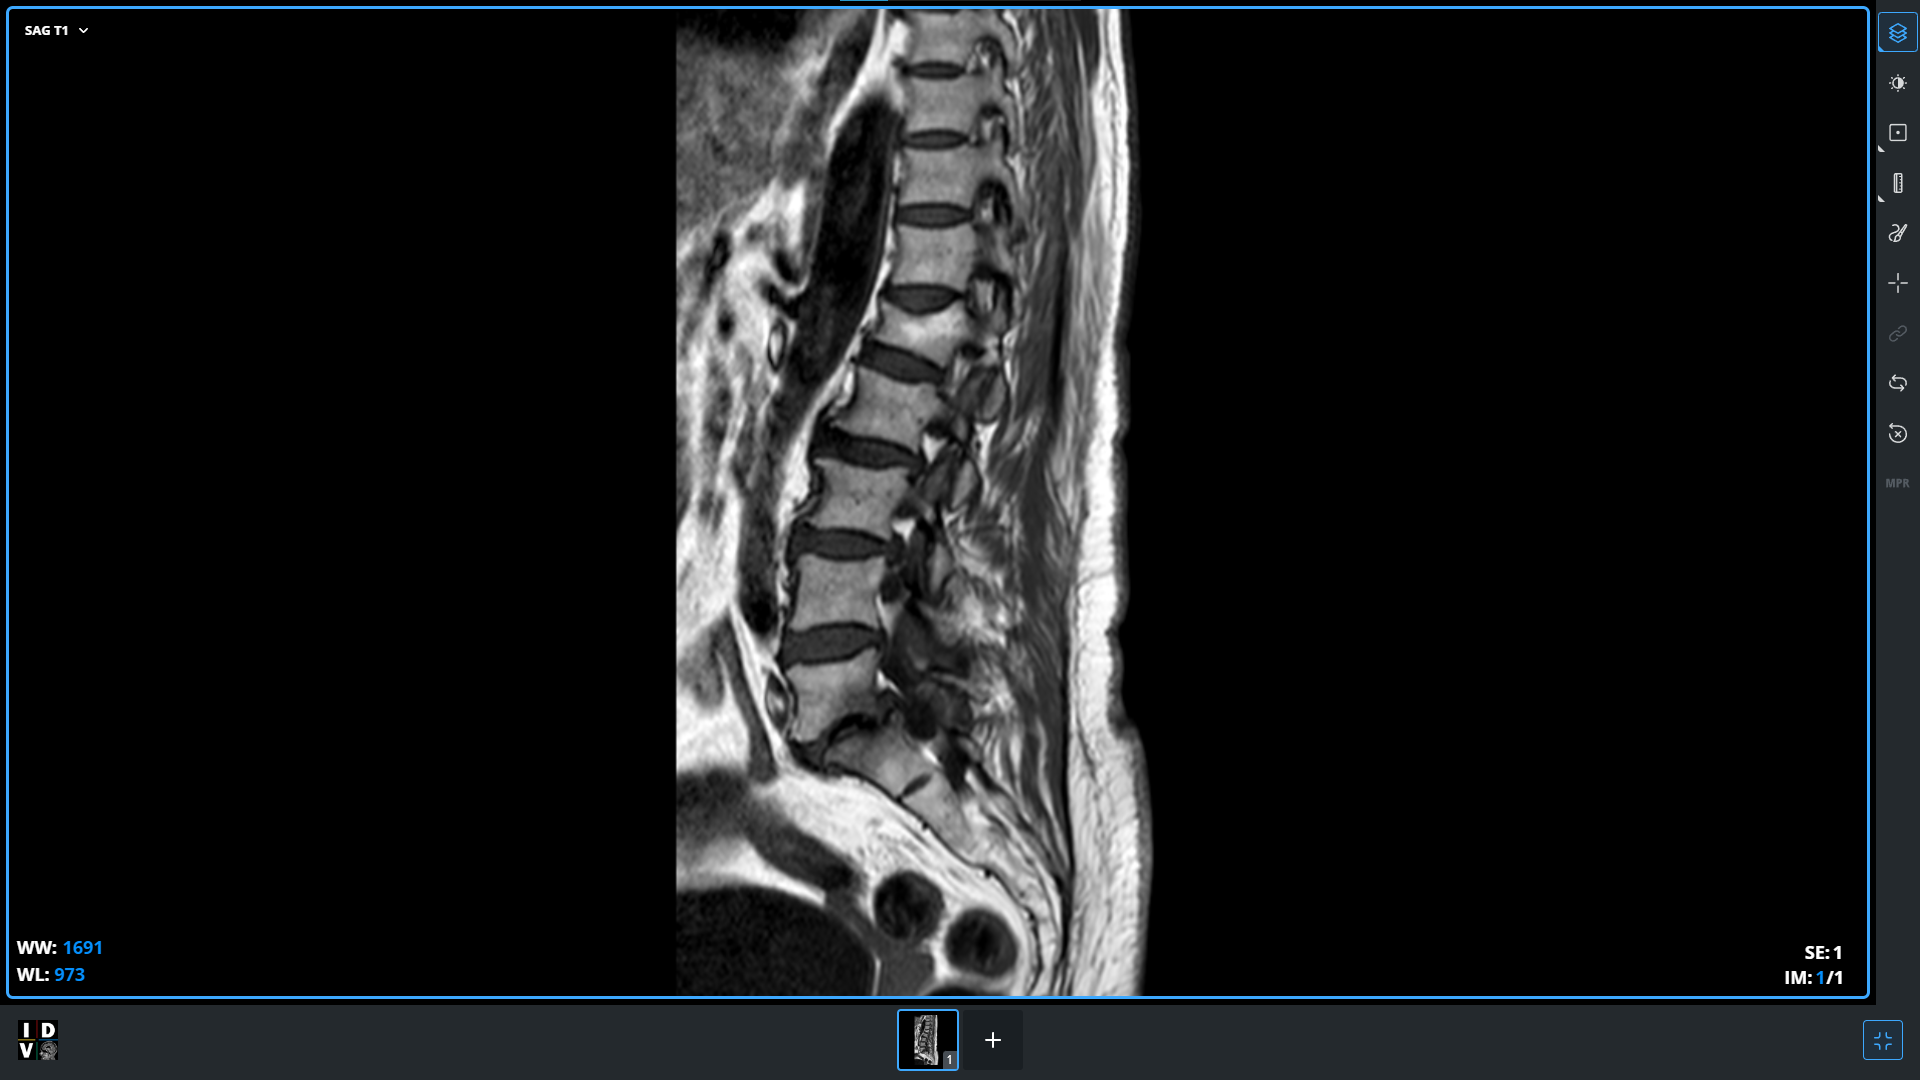
/content/1-Original_Anon_Dicom/P1/I00005.dcm.dcm aberta no visualizador web IMAIOS

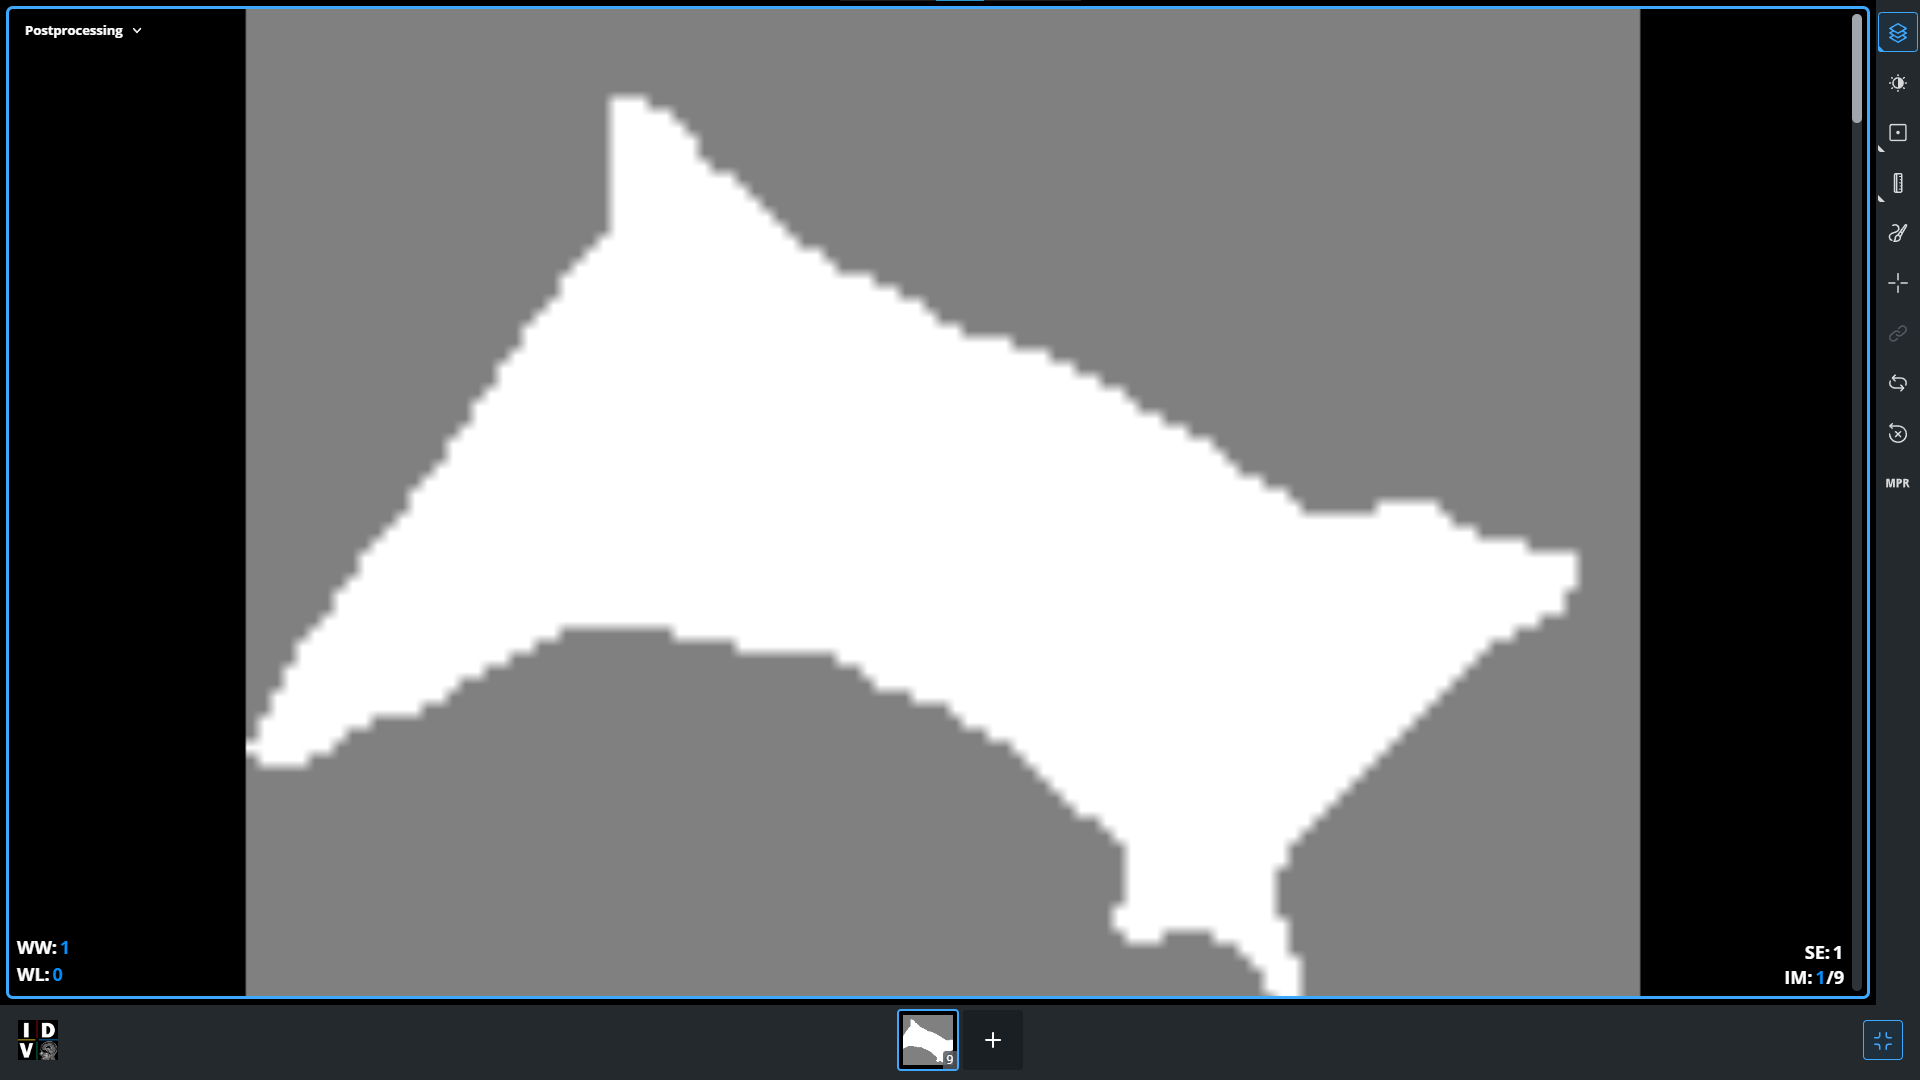

/content/3-Segmentation_NRRD/P10L1.seg.nrrd aberta no visualizador IMAIOS após conversão no Online Converter. É exibida a primeira de 9 fatias

In [ ]:
TESTEEEEEEEEEE

In [ ]:
REGJBGFIFDUGBAEZIUTGFIEURBFAUSOHFOUWERHFORSBA